In [1]:
import numpy as np
from src.PorfolioOptimizerSA import PortfolioOptimizerSA 

from src.analysis import (
    plot_cvar_history,
    return_rate_influence,
    plot_return_rate_influence,
    plot_weights,
    analyze_different_portfolios,
    plot_regulariztation_weights,
    probabilities_ifluence,
    examine_num_of_scenarios_influence
)

### Losowanie scenariuszy
Dodajemy możliwość generowania scenariuszy zmiany cen akcji. Cena akcji wówczas  $S_T = \alpha S_0$, gdzie $\alpha$ oznacza:
- duży spadek: $\alpha \sim \mathcal{N}(0.3, 0.1)$
- spadek: $\alpha \sim \mathcal{N}(0.9, 0.1)$  
- brak zmiany: $\alpha \sim \mathcal{N}(1, 0.1)$  
- wzrost: $\alpha \sim \mathcal{N}(1.2, 0.2)$  
- duży wzrost: $\alpha \sim \mathcal{N}(1.5, 1)$

Wybór współczynnika $\alpha$ odbywa się losowo z powyższych rozkładów z prawdopodobieństwami $[0.1, 0.2, 0.4, 0.2, 0.1]$. Dodatkowo, zawsze wymuszamy, by przynajmniej jedna akcja w scenariuszu miała wzrost (aby możliwe było osiagnięcie stopy zwrotu).

In [2]:
def generate_scenarios(S_0, number_of_scenarios=1000):
    """
    Generuje losowe scenariusze na podstawie stanu początkowego.
    
    """
    
    p = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
    scenarios = np.zeros((number_of_scenarios, len(S_0)))
    for i in range(number_of_scenarios):
        coefs = [np.random.normal(0.3, 0.1), 
                 np.random.normal(0.9, 0.1),
                 np.random.normal(1, 0.1),
                 np.random.normal(1.2, 0.2),
                 np.random.normal(1.5, 1)]
        chosen = np.random.choice(coefs, size=len(S_0), p=p)
        
        # ensure at least one growth
        if not np.any(np.array(chosen) > 1):
            idx = np.random.randint(len(S_0))
            chosen[idx] = np.random.uniform(1.01, 1.1)
        
        S_T = S_0 * chosen
        scenarios[i] = S_T
    
    return scenarios
    


prawdopodobieństwo występienia i-tego scenariusza $p_i$ nie jest jednostajne - zakładamy pewną wiedzę ekspercką o rynku

In [3]:
# stan początkowy
S_0 = np.array([100, 100, 100, 100, 100])

# stany
S_T = generate_scenarios(S_0, number_of_scenarios=1000)

# prawdopodobieństwa
probabilities = 1 / np.arange(1, S_T.shape[0] + 1)
# prawdopodobieństwa znormalizowane
probabilities /= probabilities.sum()

probabilities_uniform = np.ones(S_T.shape[0]) / S_T.shape[0]

# poziom ufności
alpha = 0.95

# wartość portfela na początku
V_0 = 10000

# stopa zwrotu
return_rate = 0.05

# parametry symulowanego wyżarzania
T_0 = 1000  # początkowa temperatura
T_f = 0.00001  # temperatura końcowa
max_iter = 1000  # maksymalna liczba iteracji
step_size = 0.1  # wielkość kroku
annealing_rate = 0.99  # współczynnik chłodzenia

### Proces optymalizacji

Path 1: Final CVaR = 6038.5476
Path 2: Final CVaR = 6058.8475
Path 3: Final CVaR = 5948.0288
Path 4: Final CVaR = 5944.4122
Path 5: Final CVaR = 6016.6068
Path 6: Final CVaR = 6106.0472
Path 7: Final CVaR = 6029.7450


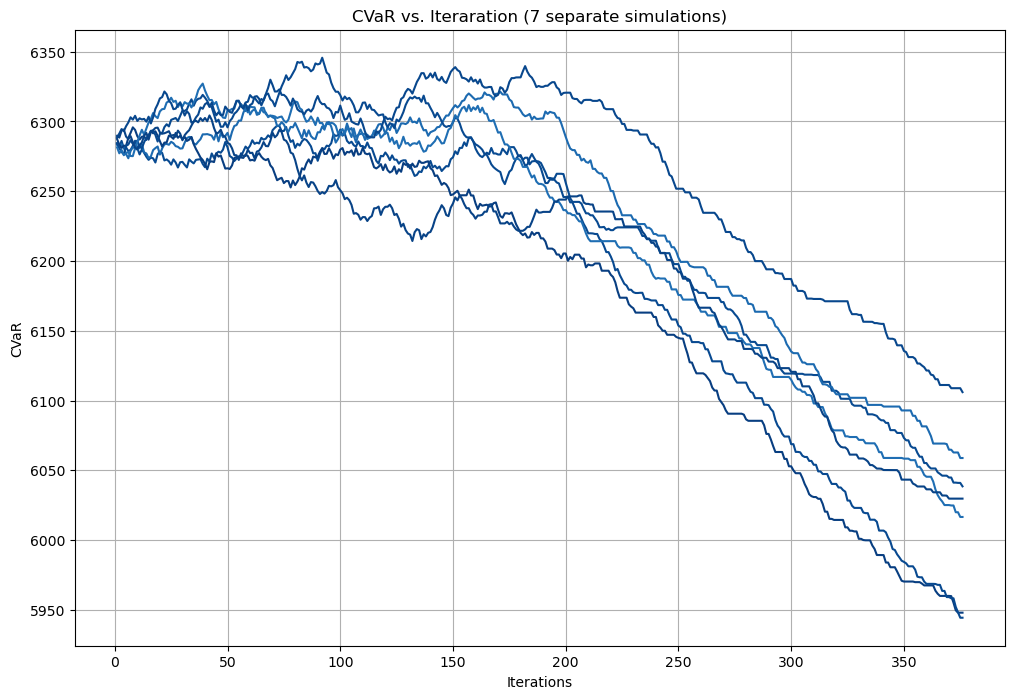

In [27]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities,
                  alpha = alpha,
                  S_0 = S_0,
                  S_T = S_T,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=7)

### Wpływ stopy zwrotu

/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


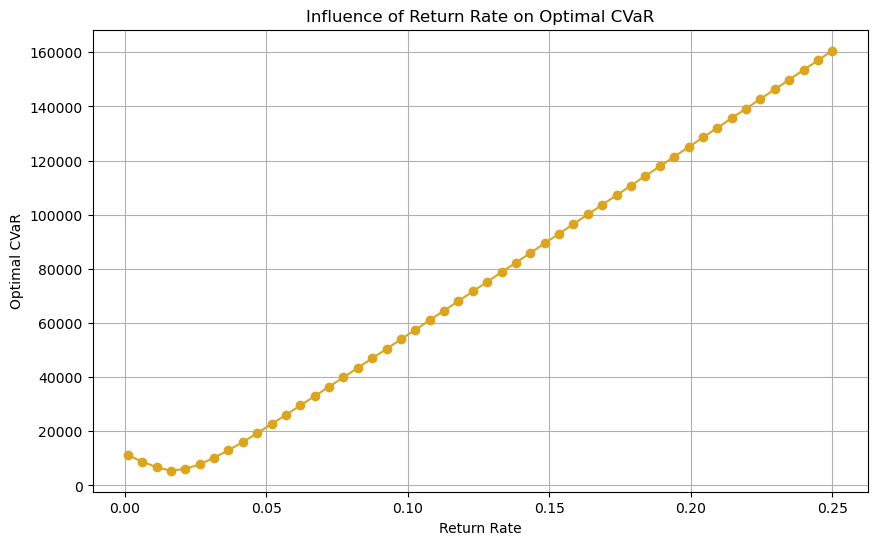

In [36]:
res = return_rate_influence(T_0=T_0,
                            T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities_uniform,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rates=np.linspace(0.001, 0.25, 50))
plot_return_rate_influence(res)

### Zmiana ilości akcji w portfelu w procesie optymalizacji

In [30]:
optimizer = PortfolioOptimizerSA(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate, 
    initial_portfolio=np.array([10, 20, 30, 40, 50])
)
optimizer.optimize()

optimal_portfolio = optimizer.x
optimal_CVaR = optimizer.calculate_CVaR(optimal_portfolio)

print("Optymalny portfel:", optimal_portfolio)
print("Wartość CVaR:", optimal_CVaR)

plot_weights(optimizer, './visualizations/weights_gen.gif', plot_every_k_iterations=5, fps=20)

Optymalny portfel: [53  7  0 12 28]
Wartość CVaR: 4525.500294870608


### Wpływ wyboru początkowego portfela

In [31]:
analyze_different_portfolios(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    probabilities=probabilities,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate,
    initial_portfolios=[np.array([10, 20, 30, 40, 50]), np.array([5, 15, 25, 35, 45]), np.array([20, 30, 40, 50, 60]),
                        np.array([0, 0, 0, 0, 100]), np.array([100, 100, 100, 100, 100]), np.array([1000, 1000, 1000, 1000, 1000])],
)

No  initial portfolio                                  optimal portfolio                                  cvar      
1   [10 20 30 40 50]                                   [51  0 14 13 22]                                   4206.3412
2   [ 5 15 25 35 45]                                   [57  8  4 12 19]                                   4630.6438
3   [20 30 40 50 60]                                   [40 -5 15 22 28]                                   3932.9258
4   [  0   0   0   0 100]                              [52  3  0  0 45]                                   4808.6659
5   [100 100 100 100 100]                              [ 13 -33  38  35  47]                              5915.8661
6   [1000 1000 1000 1000 1000]                         [-1450 -1258   925   943   940]                    204256.6270


### Regularyzacja

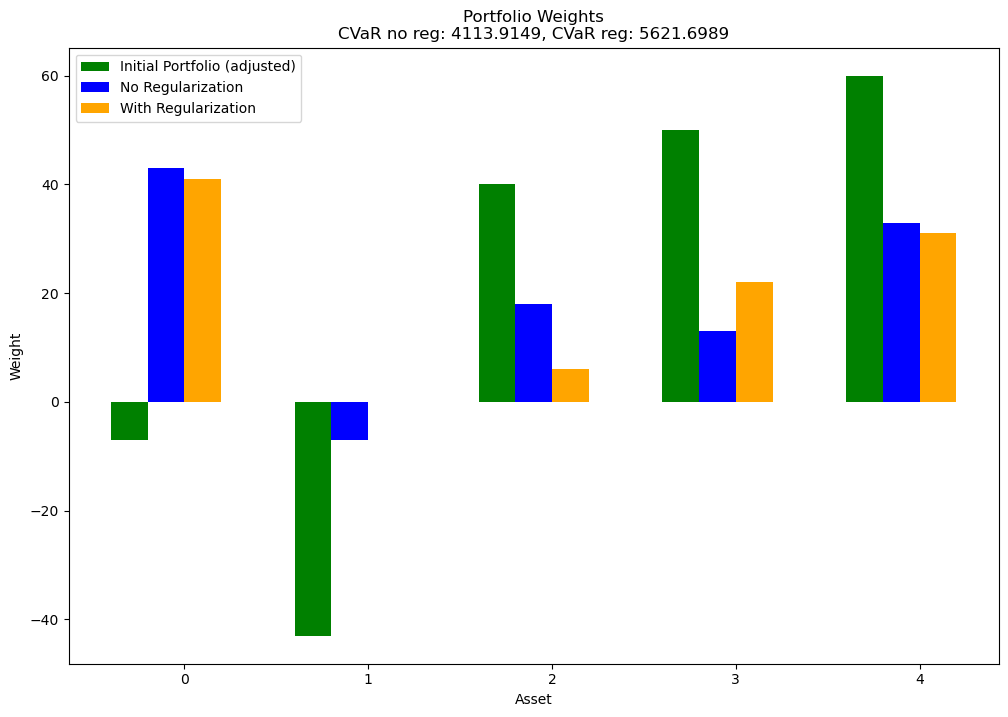

CVaR with regularization (lambda=0.5): 5621.70
CVaR without regularization: 4113.91


In [32]:
plot_regulariztation_weights(T_0=T_0,
                             T_f=T_f,
                            max_iter=max_iter,
                            step_size=step_size,
                            annealing_rate=annealing_rate,
                            probabilities=probabilities,
                            alpha=alpha,
                            S_0=S_0,
                            S_T=S_T,
                            V_0=V_0,
                            return_rate=return_rate,
                            regularization_lambda=0.5,
                            initial_portfolio=np.array([20, 30, 40, 50, 60]),)

### CVar vs. liczba mozliwych scenariuszy

In [20]:
# stan początkowy
S_0_1 = np.array([100, 100, 100, 100, 100])

# stany
S_T_1 = generate_scenarios(S_0_1, number_of_scenarios=1_000_000)

# prawdopodobieństwa
probabilities_1 = 1 / np.arange(1, S_T_1.shape[0] + 1)
# prawdopodobieństwa znormalizowane
probabilities_1 /= probabilities_1.sum()

Path 1: Final CVaR = 6521.7140
Path 2: Final CVaR = 6488.4653
Path 3: Final CVaR = 6265.3364
Path 4: Final CVaR = 6479.0536
Path 5: Final CVaR = 6395.4967


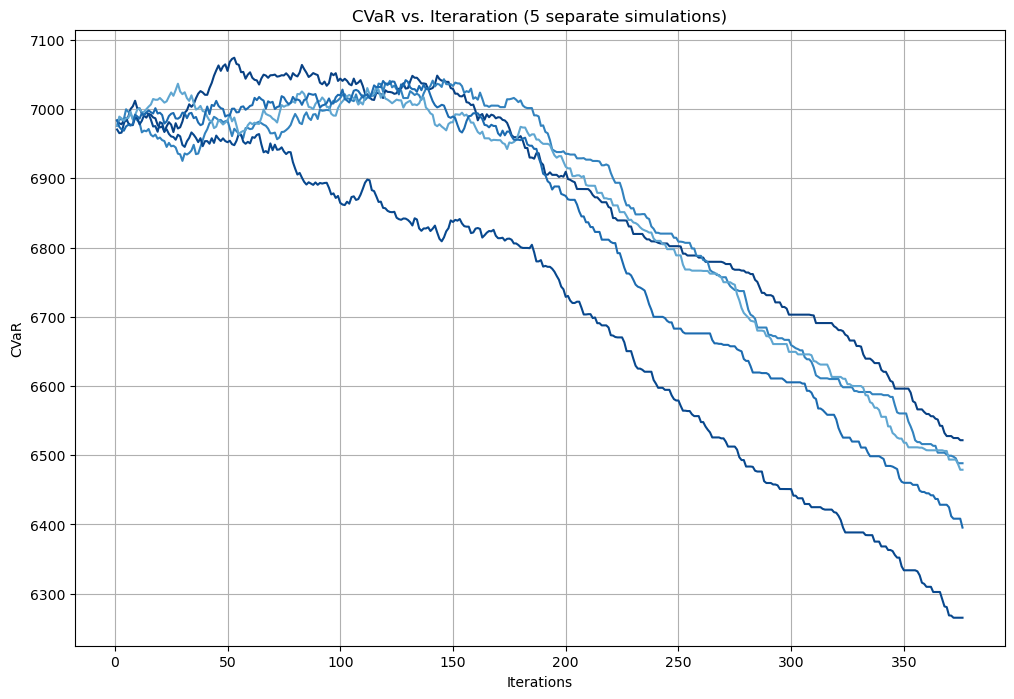

In [21]:
plot_cvar_history(T_0 = T_0,
                  T_f = T_f,
                  max_iter = max_iter,
                  step_size = step_size,
                  annealing_rate = annealing_rate,
                  probabilities = probabilities_1,
                  alpha = alpha,
                  S_0 = S_0_1,
                  S_T = S_T_1,
                  V_0 = V_0,
                  return_rate = return_rate,
                  n_paths=5)

### Wpływ prawdopodobieństw na wartość CVaR

In [52]:
probabilities_ifluence(T_0=T_0,
                            T_f=T_f,
                          max_iter=max_iter,
                          step_size=step_size,
                          annealing_rate=annealing_rate,
                          probabilities=[probabilities, probabilities_uniform],
                          alpha=alpha,
                          S_0=S_0,
                          S_T=S_T,
                          V_0=V_0,
                          return_rate=return_rate,
                          n_paths=10)

/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


|    | probabilities   |   mean_CVaR |   std_CVaR |
|----|-----------------|-------------|------------|
|  0 | non-uniform     |    37586.06 |   443.959  |
|  1 | uniform         |    21466.81 |    10.7719 |


/Users/gasparsekula/Uni/sem6/MeanVariancePortfolioMC/src/PorfolioOptimizerSA.py:152: RuntimeWarning: overflow encountered in exp
  p_accept = min(1, np.exp(-delta_CVaR / T))


Zakończono obliczenia dla 100 scenariuszy.
Zakończono obliczenia dla 1000 scenariuszy.
Zakończono obliczenia dla 10000 scenariuszy.
Zakończono obliczenia dla 100000 scenariuszy.
Zakończono obliczenia dla 1000000 scenariuszy.


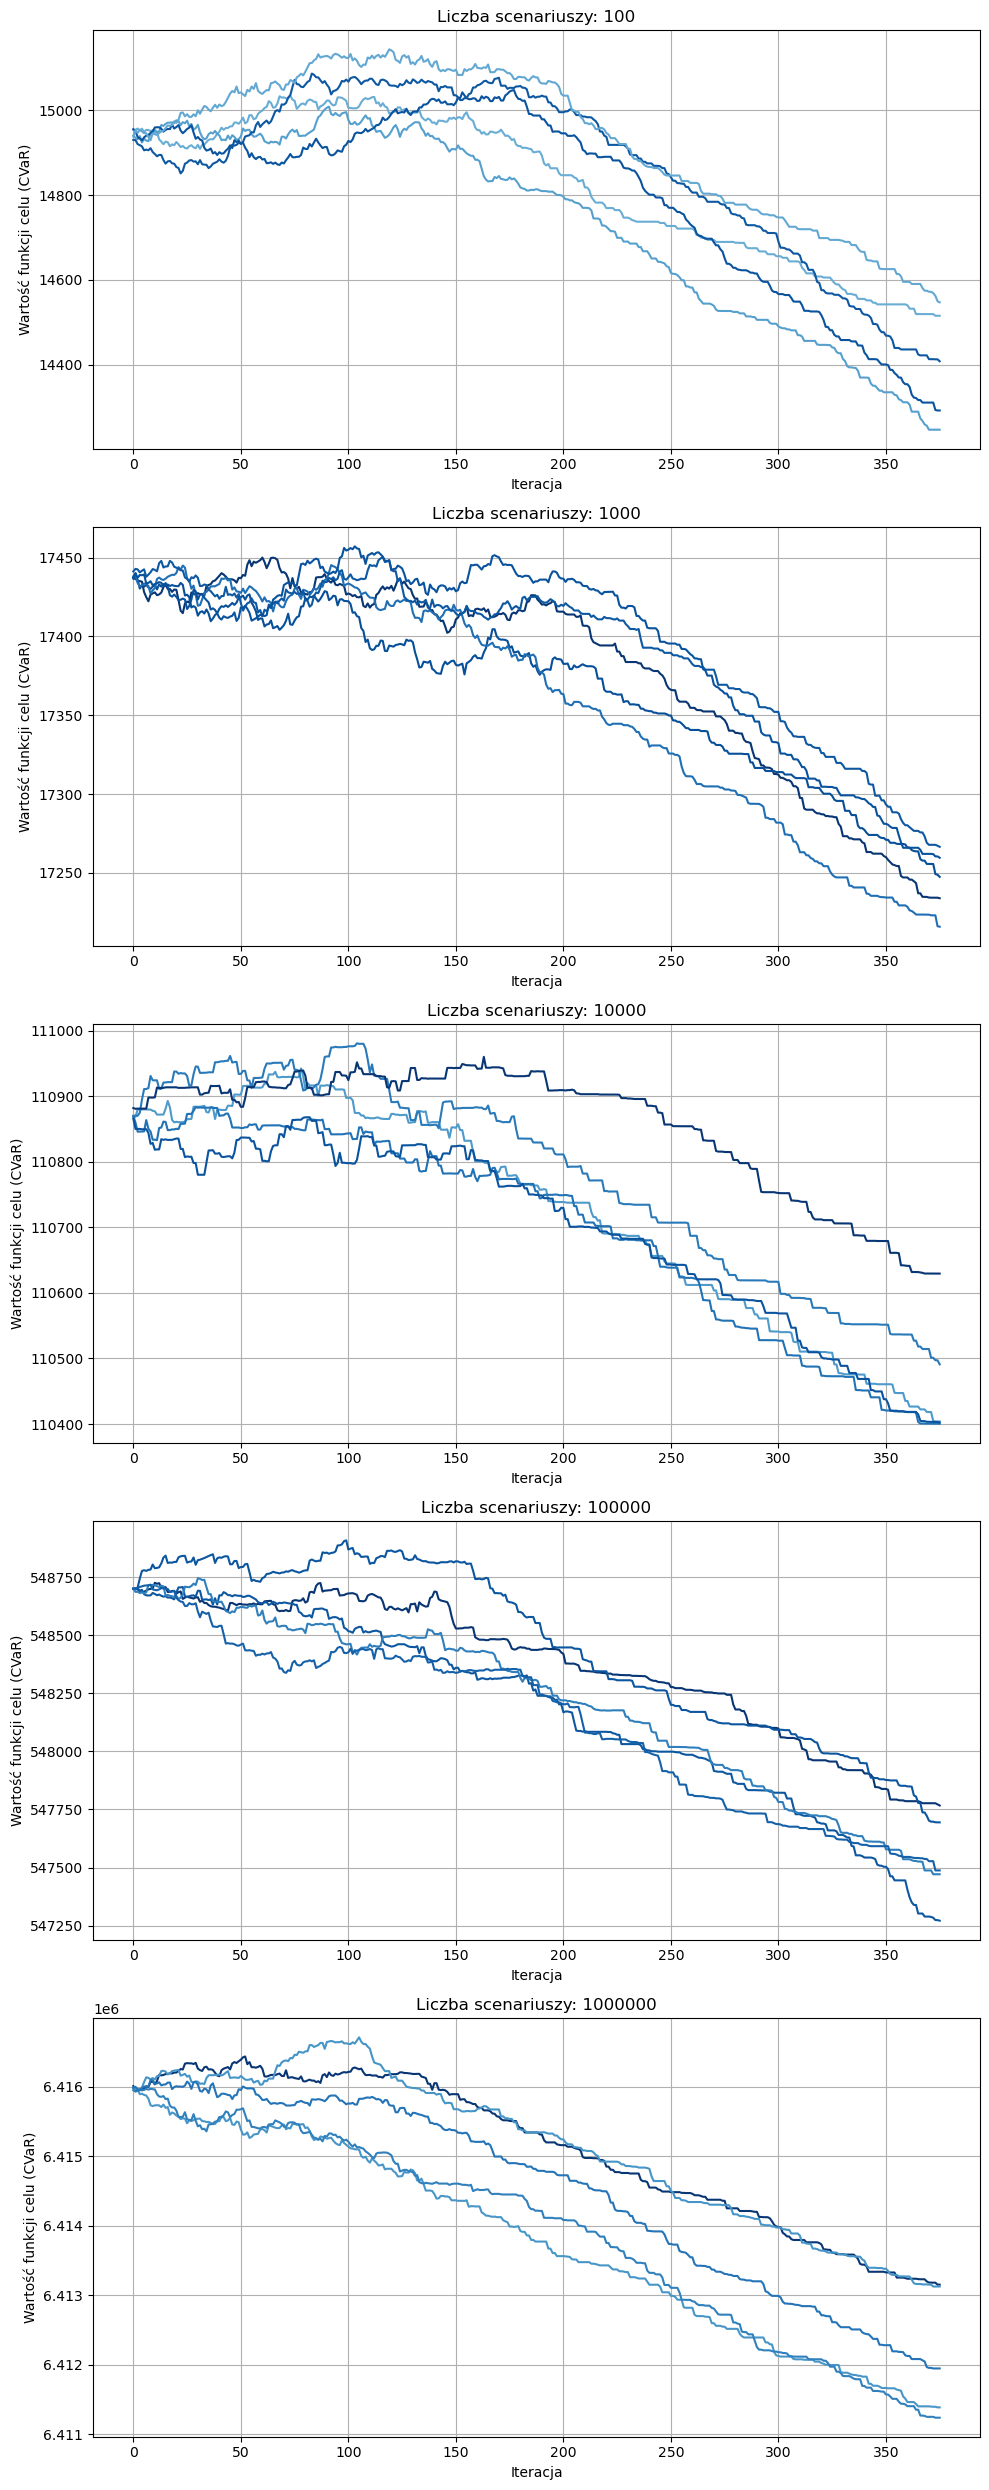

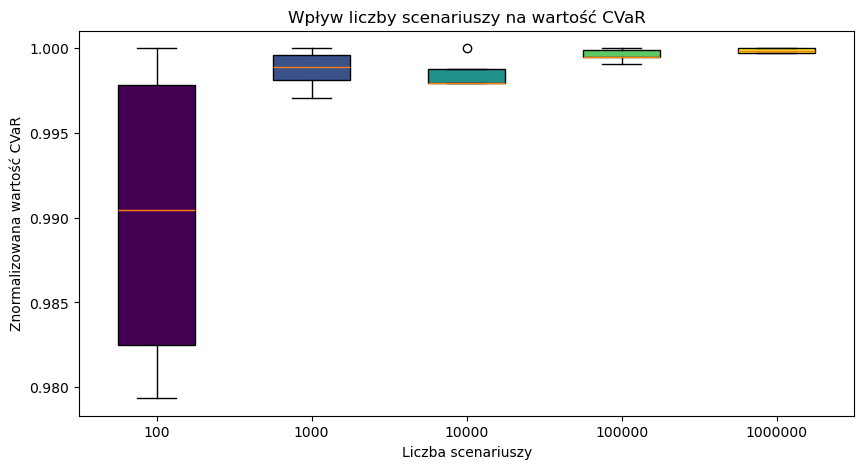

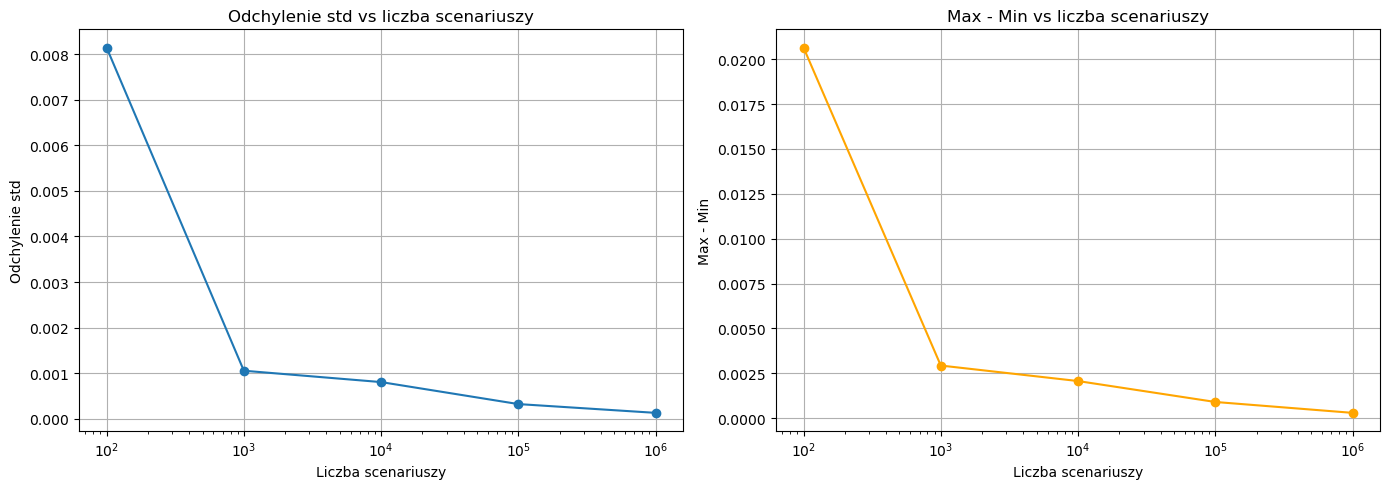

  Liczba scenariuszy    Średnia    Odchylenie std    Max - Min
--------------------  ---------  ----------------  -----------
                 100   0.990016          0.008143     0.020650
                1000   0.998734          0.001053     0.002935
               10000   0.998517          0.000804     0.002071
              100000   0.999582          0.000321     0.000905
             1000000   0.999847          0.000129     0.000299


{100: array([0.9978229 , 0.97935025, 0.98246553, 0.99044353, 1.        ]),
 1000: array([0.99811129, 0.99889643, 0.99706491, 1.        , 0.99959787]),
 10000: array([0.99795956, 0.99792928, 0.9987476 , 0.99794766, 1.        ]),
 100000: array([1.        , 0.99986738, 0.99909499, 0.99945998, 0.99948998]),
 1000000: array([0.99972453, 1.        , 0.99999579, 0.9997014 , 0.99981191])}

In [4]:
examine_num_of_scenarios_influence(
    T_0=T_0,
    T_f=T_f,
    max_iter=max_iter,
    step_size=step_size,
    annealing_rate=annealing_rate,
    alpha=alpha,
    S_0=S_0,
    S_T=S_T,
    V_0=V_0,
    return_rate=return_rate,
    nums_of_scenarios=[100, 1000, 10000, 100000, 1000_000],
    n_paths=5,
    probabilities='uniform'
)